# Exp 15. 다양한 OCR 모델 비교하기

---

# 🗼목차
Step 0. 라이브러리 불러오기  
Step 1. 검증용 데이터셋 준비  
Step 2. Keras-ocr 테스트 진행  
Step 3. Tesseract로 테스트 진행  
Step 4. Google OCR로 테스트  
Step 5. 테스트 결과 정리  
Step 6. 결과 분석과 결론 제시  
🌞회고

---

# Step 0. 라이브러리 불러오기

In [1]:
import os
import glob

import matplotlib.pyplot as plt

# Keras-ocr
import keras_ocr

# tesseract
import pytesseract
from PIL import Image
from pytesseract import Output

In [2]:
print(keras_ocr.__version__)
print(pytesseract.__version__)

0.8.8
0.3.8


---

# Step 1. 검증용 데이터셋 준비 

In [3]:
img_path = os.getenv('HOME') + '/aiffel/ocr_ads'

In [4]:
ads = os.listdir(img_path)
ads

['mcdonald.jpg',
 'the_newyork_times.jpg',
 'feel_the_rhythm_of_Korea.jpg',
 'heineken.jpg',
 'bus_wrapping.jpg',
 'marvel.jpg',
 'heal.jpg',
 'bombas.jpg',
 'siemens.jpg']

---

# Step 2. Keras-ocr 테스트 진행

* `keras_ocr.pipeline.Pipeline()`는 인식을 위한 파이프라인을 생성하는데, 이때 초기화 과정에서 미리 학습된 모델의 가중치(weight)를 불러오게 된다. (검출기와 인식기를 위한 가중치)

In [5]:
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


* 만들어둔 파이프라인의 `recognize()`에 이미지를 넣어주자.

In [6]:
images = [keras_ocr.tools.read(os.path.join(img_path, ad)) for ad in ads]
prediction_groups = [pipeline.recognize([os.path.join(img_path, ad)]) for ad in ads]

* 인식된 결과를 `pyplot`으로 시각화해보자.
* 내부적으로 `recognize()`는 검출기와 인식기를 두고, 검출기로 바운딩 박스를 검출한 뒤, 인식기가 각 박스로부터 문자를 인식하는 과정을 거치도록 한다.

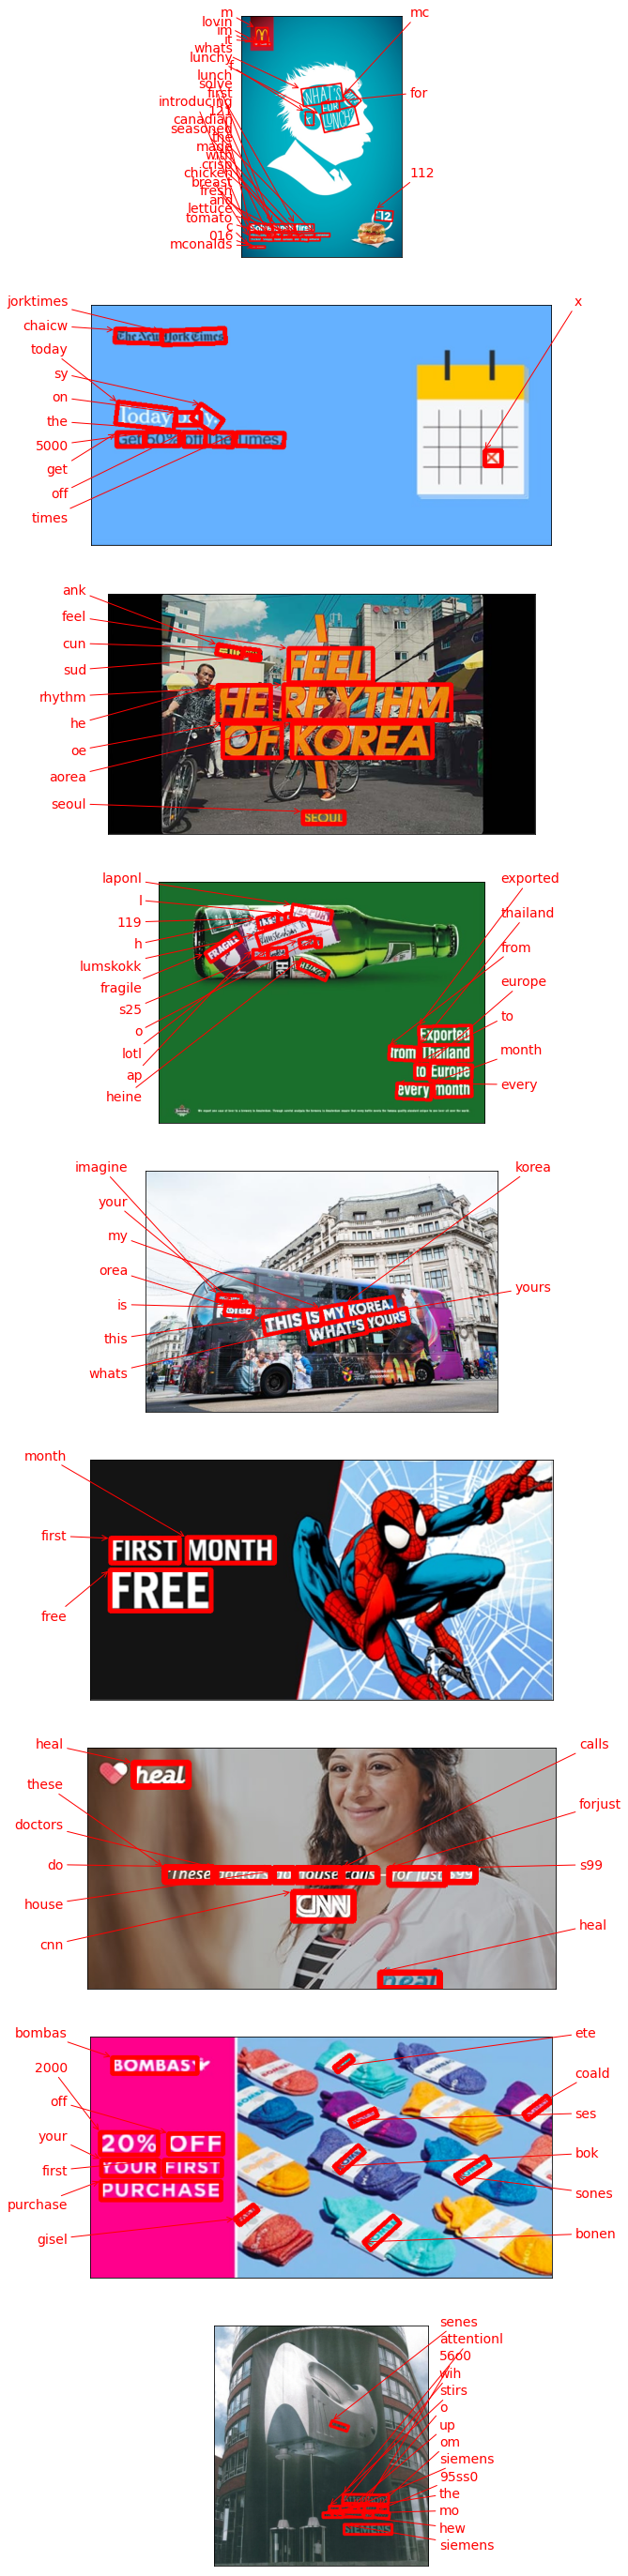

In [7]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(50, 50))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

---

# Step 3. Tesseract로 테스트 진행
* 테서렉트는 구글에서 후원하는 OCR 오픈소스 라이브러리이다.

* 테서렉트를 설치해보자.

In [8]:
# $ sudo apt install tesseract-ocr
# $ sudo apt install libtesseract-dev

* 테서랙트 파이썬 wrapper 설치해보자.
* `Pytesseract`는 OS에 설치된 테서랙트를 파이썬에서 쉽게 사용할 수 있도록 해주는 래퍼 라이브러리다.
* 파이썬 내에서 컴퓨터에 설치된 테서랙트 엔진의 기능을 바로 쓸 수 있도록 해준다.

In [9]:
# $ pip list | grep pytesseract

* 테서랙트로 문자를 검출하고 이미지를 잘라보자 (detection)
* `crop_word_regions`함수는 테스트 이미지를 받아서 문자 검출을 진행한 후 검출된 문자 영역을 crop한이미지로 만들어 그 파일들의 list를 리턴하는 함수이다.
    
    
* 기본적으로 `pytesseract.image_to_data()`를 사용한다.
* 파이썬에서 편하게 사용하기 위해서 `pytesseract`의 `Output`을 사용해서 결괏값의 형식을 딕셔너리 형식으로 설정해 주게 된다.
* 이렇게 인식된 결과는 바운딩 박스의 left, top, width, height 정보를 가지게 된다.
* 바운딩 박스를 사용해 이미지의 문자 영역들을 파이썬 `PIL(pillow)` 또는 `opencv` 라이브러리를 사용해 잘라서 `cropped_image_path_list`에 담아 리턴하였다.

In [10]:
# 테서랙트의 언어팩을 설치해야 lang = 'kor'로 바꿔도 에러가 안 남
# $ sudo apt install tesseract-ocr-kor

* `crop_word_regions`함수는 테스트 이미지를 받아서 문자 검출을 진행한 후 검출된 문자 영역을 crop한이미지로 만들어 그 파일들의 list를 리턴하는 함수

In [11]:
def recognize_images(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
            
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

* 검출된 바운딩 박스 별로 잘린 이미지를 넣어주면 영역별 텍스트가 결괏값으로 나오는 `image_to_string()`을 사용하게 된다.
* 인식된 결과가 실제 이미지와 맞는지 확인해보자.

In [12]:
output_path = os.getenv('HOME') + '/aiffel/OCR_ads'

for ad in ads:
    print(f'--------{ad}--------')
    recognize_images(os.path.join(img_path, ad), output_path)

--------mcdonald.jpg--------
/aiffel/aiffel/OCR_ads/0000.png
/aiffel/aiffel/OCR_ads/0001.png
/aiffel/aiffel/OCR_ads/0002.png
/aiffel/aiffel/OCR_ads/0003.png
/aiffel/aiffel/OCR_ads/0004.png
/aiffel/aiffel/OCR_ads/0005.png
/aiffel/aiffel/OCR_ads/0006.png
/aiffel/aiffel/OCR_ads/0007.png
/aiffel/aiffel/OCR_ads/0008.png
/aiffel/aiffel/OCR_ads/0009.png
/aiffel/aiffel/OCR_ads/0010.png
/aiffel/aiffel/OCR_ads/0011.png
/aiffel/aiffel/OCR_ads/0012.png
/aiffel/aiffel/OCR_ads/0013.png
/aiffel/aiffel/OCR_ads/0014.png
/aiffel/aiffel/OCR_ads/0015.png
/aiffel/aiffel/OCR_ads/0016.png
/aiffel/aiffel/OCR_ads/0017.png
/aiffel/aiffel/OCR_ads/0018.png
/aiffel/aiffel/OCR_ads/0019.png

Soive

Thavota

diene

intro

icing

iBal-.

| Pa

ade with

seasoned Cane

TIE

chicken

b

igen

mi

to

and crisp

(sy nab los.

PTE LAER ee

es

Done
--------the_newyork_times.jpg--------
/aiffel/aiffel/OCR_ads/0000.png
/aiffel/aiffel/OCR_ads/0001.png
/aiffel/aiffel/OCR_ads/0002.png
/aiffel/aiffel/OCR_ads

---

# Step 4. Google OCR로 테스트
* [Google Cloud Vision API 가이드](https://cloud.google.com/vision/docs/ocr)에서 코드를 참고하였다.

In [13]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [14]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]= os.getenv('HOME')+ '/aiffel/silken-tenure-343303-63e80137b53a.json'

In [15]:
for ad in ads:
    print(f'--------{ad}--------')
    detect_text(os.path.join(img_path, ad))

--------mcdonald.jpg--------
Texts:

"i'm lovin' it
WHAT'S
FOR
E
LNCH
12
The
Solve lunch first.
Introducing The 12", made with seasoned Canadian
chicken breast, fresh tomato and crisp lettuce.
© 2016 McDonald's
MC²
"

"i'm"

"lovin'"

"it"

"WHAT'S"

"FOR"

"E"

"LNCH"

"12"

"The"

"Solve"

"lunch"

"first."

"Introducing"

"The"

"12","

"made"

"with"

"seasoned"

"Canadian"

"chicken"

"breast,"

"fresh"

"tomato"

"and"

"crisp"

"lettuce."

"©"

"2016"

"McDonald's"

"MC²"
bounds: (487,324),(529,372),(489,407),(447,359)
--------the_newyork_times.jpg--------
Texts:

"The New York Times
Today only.
Get 50% off The Times.
|X
"

"The"

"New"

"York"

"Times"

"Today"

"only."

"Get"

"50%"

"off"

"The"

"Times."

"|X"
bounds: (584,217),(609,217),(609,242),(584,242)
--------feel_the_rhythm_of_Korea.jpg--------
Texts:

"REEL
HE RYREM
OF KOREA
PEQUD
SEOUL
"

"REEL"

"HE"

"RYREM"

"OF"

"KOREA"

"PEQUD"

"SEOUL"
bounds: (304,339),(362,339),(362,353),(304,353)
--------heineken.jpg------

---

# Step 5. 테스트 결과 정리

In [16]:
def all_result(ad):
    print('--------{Keras_ocr}--------')
    idx = ads.index(ad)
    keras_ocr.tools.drawAnnotations(image=images[idx], predictions=prediction_groups[idx][0])
    plt.show()
    
    print('--------{Tessract_ocr}--------')
    recognize_images(os.path.join(img_path, ad), output_path)
    
    print('--------{google_ocr}--------')
    detect_text(os.path.join(img_path, ad))

--------{Keras_ocr}--------


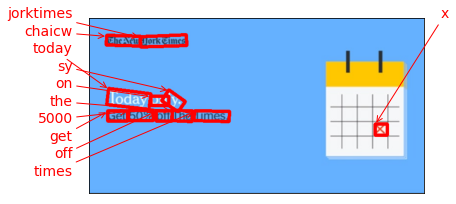

--------{Tessract_ocr}--------
/aiffel/aiffel/OCR_ads/0000.png
/aiffel/aiffel/OCR_ads/0001.png
/aiffel/aiffel/OCR_ads/0002.png
/aiffel/aiffel/OCR_ads/0003.png
/aiffel/aiffel/OCR_ads/0004.png
/aiffel/aiffel/OCR_ads/0005.png
/aiffel/aiffel/OCR_ads/0006.png
/aiffel/aiffel/OCR_ads/0007.png
/aiffel/aiffel/OCR_ads/0008.png
/aiffel/aiffel/OCR_ads/0009.png
/aiffel/aiffel/OCR_ads/0010.png
/aiffel/aiffel/OCR_ads/0011.png
che

Vow

ijork

imes

Today

eset hiZ

(5e1

ry(

rytt

ine

Times.

cor

Done
--------{google_ocr}--------
Texts:

"The New York Times
Today only.
Get 50% off The Times.
|X
"

"The"

"New"

"York"

"Times"

"Today"

"only."

"Get"

"50%"

"off"

"The"

"Times."

"|X"
bounds: (584,217),(609,217),(609,242),(584,242)


In [17]:
all_result('the_newyork_times.jpg')

--------{Keras_ocr}--------


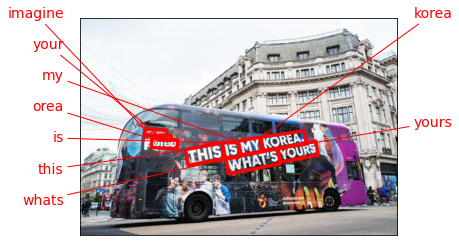

--------{Tessract_ocr}--------
/aiffel/aiffel/OCR_ads/0000.png
fi

Done
--------{google_ocr}--------
Texts:

"Imagine
your
Korea
THIS IS MY KOREA.
WHAT'S YOURS
shorea.ock
Otelondon
"

"Imagine"

"your"

"Korea"

"THIS"

"IS"

"MY"

"KOREA."

"WHAT'S"

"YOURS"

"shorea.ock"

"Otelondon"
bounds: (405,370),(446,368),(446,375),(405,377)


In [18]:
all_result('bus_wrapping.jpg')

--------{Keras_ocr}--------


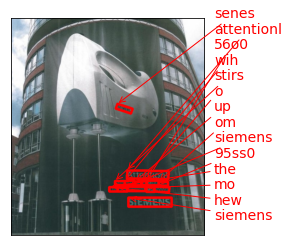

--------{Tessract_ocr}--------
/aiffel/aiffel/OCR_ads/0000.png

Done
--------{google_ocr}--------
Texts:

"SIEMENS
Attention!
Stirs with up to 5600 rpm,
The new Siemens MQ 95550.
SIEMENS
"

"SIEMENS"

"Attention!"

"Stirs"

"with"

"up"

"to"

"5600"

"rpm,"

"The"

"new"

"Siemens"

"MQ"

"95550."

"SIEMENS"
bounds: (326,503),(440,503),(440,522),(326,522)


In [19]:
all_result('siemens.jpg')

---

# Step 6. 결과 분석과 결론 제시

### 1) 서비스 목적과 내용
* 지면광고, 옥외광고 등 광고 내에 있는 카피를 인식하여 각 브랜드, 제품 별로 어떤 카피가 쓰였는지 등 쉽게 비교하기 위한 목적을 가진 서비스를 제공한다는 가정하에 프로젝트를 진행하였다.
* 지면광고, SNS 광고 뿐만 아니라 옥외광고, 심지어 버스에 래핑된 광고까지 텍스트 인식이 되는지 궁금하여 진행해보았다.
* 광고 속 카피 중 반드시 인식을 해야 하는 카피는 `브랜드명`과 `메인카피`이다.

### 2) 목적에 부합하는가?
#### [The New York Times]
| 목적 | Keras | Tesserate | Google |
| ---- | ----- | --------- | ------ |
| 브랜드명 | X | X | O |
| 메인카피 | X | X | O |

* 뉴욕 타임즈 지면 광고 내 브랜드명이 필기체로 되어있어 인식을 과연 할 수 있을까가 관건이었다.
* `Keras`는 브랜드명은 물론, 메인카피까지 인식을 제대로 하지 못하였다. 
* 50%를 할인한다는 것이 매우 중요한 사실인데, '5000'으로 인식하였다.
* `Tesserate`도 `Keras`와 동일하다.
* `Google`은 생각 이상으로 인식이 매우 잘 되었다.
* 브랜드명, 메인카피 모두 깔끔하게 인식하였으며, 대문자 처리까지 완벽했다.
    
    
#### [Bus_wrapping]
| 목적 | Keras | Tesserate | Google |
| ---- | ----- | --------- | ------ |
| 브랜드명 | △ | X | O |
| 메인카피 | O | X | O |

* `Keras`는 브랜드명에서 약간의 오류가 있었지만 거의 인식했다.
* `Tesserate`의 경우, 이미지 crop도 되지 않았으며, 'fi'라고만 인식을 하였다.
* `Google`은 완벽하게 인식하였다.

#### [SIEMENS]
| 목적 | Keras | Tesserate | Google |
| ---- | ----- | --------- | ------ |
| 브랜드명 | O | X | O |
| 메인카피 | X | X | O |

* `Keras`가 버스 래핑 광고 텍스트를 잘 인식하여 옥외광고도 기대하였지만 메인 카피를 제대로 인식하지 못하였다.
* 글씨가 작고 모여있는 텍스트를 잘 인식하지 못하는 것 같다.
* `Tesserate`는 이번에도 이미지 crop도 되지 않았으며,아예 텍스트를 인식하지 못하였다.
* `Google`은 메인카피, 브랜드명은 물론, 광고 속 제품 내에 기재된 브랜드명까지 완벽하게 인식하였다.
    
   
### 3) 결론
* `Google OCR`의 성능이 압도적으로 우수하였다.
* 그에 비해 `Tesserate`는 텍스트를 거의 인식하지 못하는 수준이었다.
* `Keras OCR`은 이미지에 따라 성능 차이가 있는 점이 다소 아쉬웠다.

---

# 🌞회고
* 어떤 목적으로 이번 프로젝트를 진행해볼까 고민하다가, 오랜만에 광고를 살펴보았다. (역시나 남이 만든 광고를 보는건 제일 재밌다.)
* 사실 광고는 메인카피 뿐만 아니라 시각적인 이미지 부분이 매우 중요하지만, 이렇게 카피를 정리하여 참고하는 것도 좋겠다는 생각으로 광고 이미지로 프로젝트를 진행하였다.
* 이번 프로젝트를 진행하는데, 생각보다 많은 오류들이 나서 꽤 애를 먹었다.
* 특히 Google OCR을 해보는데, 왜 안 될까 해보았는데 알고보니 결제 정보를 입력하지 않았다.. 입력하니 바로 오류가 뜨지 않았음...
* 포기하지 않고 Google OCR을 해본 게 매우 잘한듯하다! 어쩜 이렇게 완벽하게 텍스트를 인식할까. 진짜 구글답다.
* 테스트 결과 정리를 각 OCR 별로 했었는데, 뭔가 지저분해서 고민하다가 지난 주에 우수 프로젝트에서 함수로 다 정리하셨던 분의 발표가 생각이 나 함수로 한번 구현해보았다.
* `Keras`, `Tesseract`, `google OCR`을 비교하며 보니 명확하게 성능 차이를 알 수 있었다.
* 이번 프로젝트의 결론은 가장 성능이 좋은 모듈은 `Google OCR API`이라는 것이다.